In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os, re, io
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

import tensorflow as tf

resolver=tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.34.155.74:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.34.155.74:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data_copy = data
data_copy.shape

(98401, 2)

In [4]:
data.sample(10)

,headlines,text
14800,Air India apologises after passengers locked i...,Air India on Wednesday rendered an apology a d...
43540,Harvard-backed firm aims for minimally invasiv...,Paris-based startup HoliStick Medical is devel...
45590,Aqueous battery that can be charged within 30 ...,South Korea-based researchers developed an aqu...
88364,Heavy rains may have shaped Mars surface: Study,Heavy rain on Mars may have reshaped its impac...
8284,Man Utd boss Mourinho throws crate of bottles ...,Manchester United manager Jose Mourinho celebr...
69506,"Note ban, hasty GST rollout affected GDP: Manm...",Former Prime Minister Manmohan Singh on Monday...
30929,No plans to regulate digital news websites: I&...,Newly appointed I&B Minister Rajyavardhan Rath...
9772,There was too much pressure on Unadkat over hi...,IPL franchise Rajasthan Royals have said they ...
64331,Punjab government dismisses reports of tax on ...,The Punjab government has dismissed reports cl...
63174,No hesitation discussing sexual relations with...,"Actor Irrfan Khan, while talking about his equ..."


In [5]:
# 전체 샘플 수 확인
print("전체 샘플 수 : ", len(data))

전체 샘플 수 :  98401


In [6]:
print("Text 중복 제외 샘플 수 : ", data["text"].nunique())
print("headlines 중복 제외 샘플 수", data["headlines"].nunique())

Text 중복 제외 샘플 수 :  98360
headlines 중복 제외 샘플 수 98280


In [7]:
# 중복 샘플 제거하기 `drop_duplicates()`사용하기

data.drop_duplicates(subset = ['text'], inplace=True)
data.drop_duplicates(subset = ['headlines'], inplace=True)

In [8]:
# 다시 전체 샘플 수 확인

print("전체 샘플 수 : ", len(data))

전체 샘플 수 :  98262


In [9]:
# null 값 결측치 확인하기
print(data.isnull().sum())
# 따로 결측치는 없어 처리해 줄 필요는 없다.

headlines    0
text         0
dtype: int64


## 텍스트 정규화와 불용어 제거

In [10]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [11]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [12]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [13]:
clean_text = []
for i in data['text']:
  clean_text.append(preprocess_sentence(i))

print("전처리 샘플 5개 : ", clean_text[:5])

전처리 샘플 5개 :  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure c

In [14]:
clean_headlines = []
for i in data['headlines']:
  clean_headlines.append(preprocess_sentence(i, False))

print("전처리 샘플 5개 : ", clean_headlines[:5])

전처리 샘플 5개 :  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


### 전처리 과정 진행 후 결측치 다시 확인해보기

In [15]:
data['text'] = clean_text
data['headlines'] = clean_headlines

data.replace("", np.nan, inplace=True)

In [16]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [17]:
data.dropna(axis=0, inplace=True)
print("전체 샘플 수 : ", len(data) )

전체 샘플 수 :  98262


텍스트의 최소 길이 :  1
텍스트의 최대 길이 :  60
텍스트의 평균 길이 :  35.10029309397326
헤드라인의 최소 길이 :  1
헤드라인의 최대 길이 :  16
헤드라인의 평균 길이 :  9.299444342675704


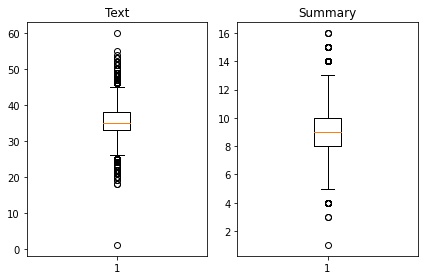

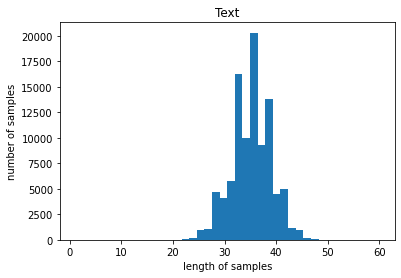

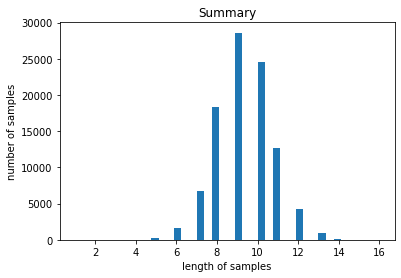

In [18]:
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : ', np.min(text_len))
print('텍스트의 최대 길이 : ', np.max(text_len))
print('텍스트의 평균 길이 : ', np.mean(text_len))
print('헤드라인의 최소 길이 : ', np.min(headlines_len))
print('헤드라인의 최대 길이 : ', np.max(headlines_len))
print('헤드라인의 평균 길이 : ', np.mean(headlines_len))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위 출력 값을 확인해보면  
텍스트의 최소 길이는 1, 최대 길이는 60, 평균 길이는 약 35 정도가 나오며,  
헤드라인의 최소 길이는 1, 최대 길이는 16, 평균 길이는 약 9 정도가 나오는 것을 볼 수 있다.

저 위 출력값과 그래프를 기준으로 text와 headlines의 적절한 최대 길이를 임의로 정한다.  

text 최대 길이 40, headlines 최대 길이 11





In [19]:
text_max_len = 40
headlines_max_len = 11

In [20]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
      cnt = cnt + 1
  print("전체 샘플 중 길이가 %s 이하인 샘플의 비율 = %s" %(max_len, (cnt / len(nested_list))))


In [21]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율 = 0.92383627444994
전체 샘플 중 길이가 11 이하인 샘플의 비율 = 0.9450041725183692


약 90% 이상의 샘플들이 유지 되는 것을 확인할 수 있다.  
이대로 진행한다.

In [22]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x : len(x.split()) <= headlines_max_len)]
print("전체 샘플 수 : ", len(data))

전체 샘플 수 :  85756


### 시작 토큰 종료 토큰 추가하기

시작 토큰 sos, 종료 토큰 eos

In [23]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sos ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eos')
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sos upgrad learner switches to career in ml al...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sos new zealand end rohit sharma led india mat...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sos aegon life iterm insurance plan helps cust...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sos rahat fateh ali khan denies getting notice...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sos govt directs alok verma to join work day b...,govt directs alok verma to join work day befor...


In [24]:
# numpy 타입으로 저장하기

encoder_input = np.array(data['text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

In [25]:
# from sklearn.model_selection import train_test_split

# x_train, x_test, y_train, y_test = train_test_split(encoder_input, )

## train_test_split으로 구분하려 했으나 그냥 예제처럼 슬라이싱 사용

In [26]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[68070  1802 56255 ... 64424 14888 83299]


In [27]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [28]:
cutcut = int(len(encoder_input)*0.2)
print('테스트 데이터 개수 : ', cutcut)

테스트 데이터 개수 :  17151


In [29]:
encoder_input_train = encoder_input[:-cutcut]
decoder_input_train = decoder_input[:-cutcut]
decoder_target_train = decoder_target[:-cutcut]

encoder_input_test = encoder_input[-cutcut:]
decoder_input_test = decoder_input[-cutcut:]
decoder_target_test = decoder_target[-cutcut:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 68605
훈련 레이블의 개수 : 68605
테스트 데이터의 개수 : 17151
테스트 레이블의 개수 : 17151


## 정수 인코딩

단어 집합 만들기

In [30]:
src_tokenizer = Tokenizer() 
src_tokenizer.fit_on_texts(encoder_input_train)

In [31]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 64701
등장 빈도가 6번 이하인 희귀 단어의 수: 44185
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20516
단어 집합에서 희귀 단어의 비율: 68.29106196194805
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.788041175864962


In [32]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합 크기 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train)  # 단어 집합 재생성

In [33]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[2215, 1175, 129, 7398, 890, 7784, 6085, 6659, 97, 6660, 5790, 622, 5016, 326, 7278, 5581, 82, 9576, 258, 6954, 3302, 6661, 7659, 4922, 4172, 2824, 409, 342, 3253, 6954, 1112, 3281, 3068, 913], [2399, 22, 220, 641, 110, 5861, 6482, 5516, 1530, 2825, 1004, 3734, 5722, 2, 14, 30, 14740, 370, 795, 1257, 952, 392, 19152, 6482, 3461, 2721, 22, 220, 314, 12251, 1014, 1612, 2399, 4878, 506], [49, 1276, 85, 1, 24, 393, 10863, 354, 19153, 1929, 50, 2238, 13, 170, 2238, 578, 1167, 6148, 33, 1, 513, 741, 102, 319, 3001, 13, 6, 3055, 6662, 302, 5862, 8361, 521, 1887]]


In [34]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [35]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28533
등장 빈도가 5번 이하인 희귀 단어의 수: 18785
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9748
단어 집합에서 희귀 단어의 비율: 65.83604948655942
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.155648183864635


In [36]:
tar_vocab = 9500
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input ',decoder_input_train[:5])
print('decoder ',decoder_target_train[:5])

input  [[1, 5663, 160, 1331, 3, 921, 7, 4420, 1043, 6683], [1, 3993, 7124, 10, 2602, 5, 3306, 7125], [1, 236, 428, 3, 53, 779, 4, 1714, 80, 630], [1, 188, 4, 53, 1129, 12, 3865, 3, 4754, 120, 234, 431], [1, 61, 4755, 6684, 79, 10, 2152, 8, 425, 94, 71]]
decoder  [[5663, 160, 1331, 3, 921, 7, 4420, 1043, 6683, 2], [3993, 7124, 10, 2602, 5, 3306, 7125, 2], [236, 428, 3, 53, 779, 4, 1714, 80, 630, 2], [188, 4, 53, 1129, 12, 3865, 3, 4754, 120, 234, 431, 2], [61, 4755, 6684, 79, 10, 2152, 8, 425, 94, 71, 2]]


## 다시 한번 빈 샘플 정리하기  
이번엔 결측치가 0이 아니라 sos, eos 토큰이 있기 때문에 1이다.

In [37]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 68604
훈련 레이블의 개수 : 68604
테스트 데이터의 개수 : 17151
테스트 레이블의 개수 : 17151


딱히 결측치가 발생하거나 하지 않았다.

# 패딩하기
이제 텍스트를 정수로 바꿔주었고, 샘플들의 길이가 다 다르기 때문에 같은 길이로 맞춰준다.   
숫자 뒤로 패딩하기


In [38]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

# 모델 설계하기

In [39]:
# 코랩 TPU 사용한 코드

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 128
hidden_size = 256

with strategy.scope():
  # 인코더 설계
  encoder_inputs = Input(shape=(text_max_len,))
  enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)
  encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
  encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
  encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
  encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
  encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
  encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

  # 디코더 입력층 설계
  decoder_inputs = Input(shape=(None,))
  dec_emb_layer = Embedding(tar_vocab, embedding_dim)
  dec_emb = dec_emb_layer(decoder_inputs)
  decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
  decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

  # 디코더 출력층 설계
  decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
  decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 
  
  # 어텐션 
  attn_layer = AdditiveAttention(name='attention_layer')
  attn_out = attn_layer([decoder_outputs, encoder_outputs])
  decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
  decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
  decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

  # 모델 정의, 훈련
  model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
  model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
  es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
  history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
            validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
            batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


268/268 [==============================] - 43s 67ms/step - loss: 6.0065 - val_loss: 5.5738
Epoch 2/50
268/268 [==============================] - 14s 52ms/step - loss: 5.4415 - val_loss: 5.1873
Epoch 3/50
268/268 [==============================] - 14s 52ms/step - loss: 5.0859 - val_loss: 4.9158
Epoch 4/50
268/268 [==============================] - 14s 53ms/step - loss: 4.8229 - val_loss: 4.7253
Epoch 5/50
268/268 [==============================] - 14s 53ms/step - loss: 4.6056 - val_loss: 4.5865
Epoch 6/50
268/268 [==============================] - 14s 53ms/step - loss: 4.4223 - val_loss: 4.4633
Epoch 7/50
268/268 [==============================] - 14s 53ms/step - loss: 4.2639 - val_loss: 4.3597
Epoch 8/50
268/268 [==============================] - 14s 53ms/step - loss: 4.1235 - val_loss: 4.2807
Epoch 9/50
268/268 [==============================] - 14s 53ms/step - loss: 3.9976 - val_loss: 4.2163
Epoch 10/50
268/268 [==============================] - 14s 53ms/step - loss: 3.8873 - val_los

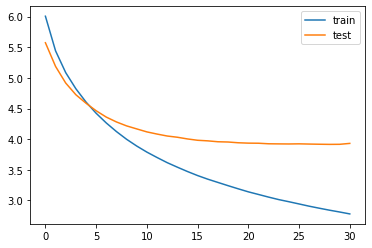

In [40]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 인퍼런스 모델 구현하기

테스트 단계 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 한다    
3개의 사전을 미리 준비


In [41]:
# 원문 단어 집합, 정수->단어 겟
src_index_to_word = src_tokenizer.index_word
# 요약 단어 집합, 단어->정수 겟
tar_word_to_index = tar_tokenizer.word_index
# 요약 단어 집합, 정수->단어 겟
tar_index_to_word = tar_tokenizer.index_word

In [42]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

### 어텐션 메커니즘 사용하는 출력층 설계

In [43]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [44]:
# 인퍼런스 단계에서 단어 시퀀스 완성하는 함수

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sos']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eos'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eos'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# 모델 테스트하기

정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는게 편하다.   
주어진 정수 시퀀스로 변환하는 함수를 만든다.   
Text 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0 제외,   
headlines 정수 시퀀스에서는 숫자 0, 시작토큰, 종료토큰 인덱스 출력을 제외하도록 한다.

In [45]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sos']) and i!=tar_word_to_index['eos']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [46]:
for i in range(0, 50):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : terrorism suspect involved foiled attack france lyon released custody judge forgot renew pre trial detention following release arrested driving without license outside probation area however released court found police testimony weak convict 
실제 요약 : terror suspect freed as judge forgets to custody term 
예측 요약 :  isis suspect arrested in new york city


원문 : sari clad man thrashed suspicion child madhya pradesh district police said works artist rescued time local police video assault emerged social media following police said would identify accused 
실제 요약 : sari clad man thrashed on suspicion of being child lifter 
예측 요약 :  video shows mob beating up cop for cow slaughter


원문 : indian leg spinner yuzvendra chahal took four wickets sri lanka wednesday become highest wicket taker chahal took wickets year surpassing afghanistan rashid khan windies williams wickets chahal england february best bowling figures year best ever indian 
실제 요약 : chahal becomes highest wicket taker in 
예측 요

# 추출적 요약 하기

#### summarize

text(str) : 요약할 테스트   
ratio(float, optional) : 요약문에서 원본으로 선택되는 문장 비율 (0~1 사이값)   
words(int or None, optional) : 출력에 포함할 단어 수   
split(bool, optional) : True면 list, False면 join된 문자열 반환  
 

>`추출적 요약하기는 왜 인지 모르겠지만 계속해서 오류가 발생해서 별도의 다른 파일로 올리게 되었습니다.`

# 회고

이번 뉴스 기사를 요약하는 과정은 꽤나 재미가 있었다.   
다만 아쉬운 점이 있다면 인퍼런스 모델 구현이 아직 완벽하게 이해가 되지 않았고, 추상적 요약 모델의 val_loss가 안잡혔다는 점이다.  
모델이 학습한 그래프를 확인해봐도 앞서 노드를 실습하면서 봤던 그래프와는 너무 차이가 크고 결과를 확인해 봐도 눈에 띄는 오류가 많아보인다.   

#### 실제 headlines, 예측 headlines 차이 확인해보기
#### 영어를 못해서 번역기의 힘을 빌렸습니다

died injured in terrace collapse during dussehra event   
dead injured as bridge collapses in west bengal  

dussehra 행사 중 테라스 붕괴로 부상 사망   
서부 벵골서 다리 붕괴로 사망  

india will be rd largest aviation market by foreign secy   
india longest of world largest economy in yrs  

인도는 외국에서 세 번째로 큰 항공 시장이 될 것입니다.  
인도는 몇 년 동안 세계 최대 경제의 가장 긴   

infosys names as interim cfo   
infosys ceo resigns after infosys exit exit  

infosys 이름을 임시 cfo로 지정   
인포시스 CEO, 인포시스 퇴장 후 사임   

will show vijender what chinese are capable of   
china will not be good like in india china  

중국인이 무엇을 할 수 있는지 vijender를 보여줄 것입니다   
중국은 인도 중국처럼 좋지 않을 것입니다   

kxip mayank agarwal ties the knot with girlfriend   
dhoni posts video of ipl match in ipl match  

kxip mayank agarwal, 여자 친구와 결혼   
dhoni는 ipl 경기에서 ipl 경기의 비디오를 게시합니다.   

new zealand beat pakistan to take lead in series   
pakistan beat pakistan to win their th odi series  

뉴질랜드, 파키스탄 꺾고 시리즈 1위   
파키스탄, 파키스탄 꺾고 odi 시리즈 우승  

hanuman was gods have no caste up sports minister   
lord lord hanuman is lord lord hanuman mamata  

하누만 신은 계급이 없는 스포츠 장관이었다   
군주 하누만은 군주 하누만 마마타입니다  

no party will get majority in ncp chief sharad pawar   
opposition parties to take trust motion against nda  

어떤 정당도 ncp 수석 샤라드 파와르에서 과반을 차지하지 못할 것입니다.   
야당, NDA 반대 신탁 동의   

indian men hockey team beat japan cross goals in games   
indian women hockey team beats world cup for  

인도 남자 하키 팀은 게임에서 일본 크로스 골을 이겼습니다.   
인도 여자 하키 팀, 월드컵 우승   

>대충 슥 보기만 해도 조금 심각하게 많이 틀리는 것을 알 수 있다.   
val_loss를 잡지 못한 결과물인 듯

## 두 요약 결과 비교

이 글에는 없고 따로 참고자료로 올리겠지만   
추상적요약과 추측적 요약을 비교해보면 

## 추측적 요약의 일부

upGrad learner switches to career in ML & Al with 90% salary hike
upGrad's Online Power Learning has powered 3 lakh+ careers.

upGrad 학습자는 90% 급여 인상과 함께 ML 및 Al에서 경력으로 전환  
upGrad의 온라인 파워 러닝은 3 lakh 이상의 경력을 제공했습니다.  

Delhi techie wins free food from Swiggy for one year on CRED
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.

델리 기술자는 CRED에서 1년 동안 Swiggy에서 무료 음식을 얻습니다.  
사용자는 지불한 청구서의 루피당 하나의 CRED 코인을 받게 되며, 이 코인은 Ixigo, BookMyShow, UberEats, Cult.Fit 등과 같은 브랜드의 보상을 이용하는 데 사용할 수 있습니다.  


New Zealand end Rohit Sharma-led India's 12-match winning streak
The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.

뉴질랜드, 로히트 샤르마 주도 인도의 12경기 연속 무패 행진 종료  
이 경기에서 인도는 ODI 크리켓 역사상 7번째로 낮은 합계인 92타를 기록했습니다.  

Aegon life iTerm insurance plan helps customers save tax
Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years.

Aegon life iTerm 보험은 고객이 세금을 절약하도록 도와줍니다.  
또한 고객은 최대 80세까지 생명을 보장하는 중대 질병, 장애 및 사고 사망 보험금 특약에 대해 보험에 가입할 수 있습니다.  

Cong wins Ramgarh bypoll in Rajasthan, takes total to 100 seats
Congress candidate Shafia Zubair won the Ramgarh Assembly seat in Rajasthan, by defeating BJP's Sukhwant Singh with a margin of 12,228 votes in the bypoll.

Cong, Rajasthan에서 Ramgarh bypoll 승리, 총 100석 차지   
하원의원 후보인 Shafia Zubair는 12,228표 차이로 BJP의 Sukhwant Singh를 꺾고 Rajasthan에서 Ramgarh 의회 의석을 차지했습니다.

결과를 비교해보면 추상적요약은 그래도 앞서 전처리 과정에서 최대 길이를 정해주는 등 다양한 처리과정을 거쳐서 그래도 어느정도 정돈된 연결이 되는 느낌을 주지만    
추출적요약은 따로 전처리를 해주지 않고 단순히 summarize 함수를 사용해 요약하다보니 길이도 제멋대로인 경향도 있고 요약이 요약같지 않은 느낌이 많이 든다   

재밌게도 몇몇 요약은 기존의 headlines을 부가 설명하는 역할을 하는 것처럼 이어지는 모습을 볼 수 있다.    

그리고 왜 인지 모르겠지만 몇몇 요약은 아예 값이 나오지 않는 요약도 있다 이는 여러번 같은 코드를 반복 실행해봤지만 여전히 안나오는 것을 확인할 수 있다 이는 제대로 해결하지 못한 과제 중 하나이다.
